In [4]:
using DrWatson
using Revise
@quickactivate :LevelSetSublimation
using LaTeXStrings
const LSS = LevelSetSublimation

LevelSetSublimation

## Set up domains

In [2]:

# Default "bandwidth" size: 20% of domain size, extending on both sides of front
# This default is built into Domain constructor

simgrid_coarse = (51, 51)
simgrid_fine = (101, 101)


(101, 101)

## Universal (or base) parameters

In [7]:
pol_kwargs = (filename=hash, prefix="simdat", verbose=false, tag=true)

params_base = make_default_params()
params_base[:Q_ic] *= 0
params_base[:Q_ck] *= 0
params_base[:Kgl] *= 0
params_base[:Kv] *= 0

dudt_func = LSS.dudt_heatonly!

init_prof = :flat

Tf0 = 233.15u"K"
Q_gl_RF = 0.0u"W" # = volumetric * relevant vial volume
t_samp = [0.0, 1.0].*u"s"
Tsh = 233.15u"K"
Q_ic = 0.0u"W/cm^3"
p_ch = 100u"mTorr"

controls = Dict{Symbol, Any}()
@pack! controls = t_samp, Q_gl_RF, Tsh, Q_ic, p_ch


vialsize = "10R"
fillvol = 2u"mL"

simgridsize = simgrid_coarse

cparams = deepcopy(params_base)
config_base = Dict{Symbol, Any}()
@pack! config_base = cparams, init_prof, Tf0, controls, vialsize, fillvol, simgridsize, dudt_func

(Dict{Symbol, Any}(:Kv => 0 W K^-1 m^-2, :m_cp_gl => 40.0 g J kg^-1 K^-1, :ϵ => 0.9, :l => 1.0e-6 m, :μ => 8.1 μPa s, :p_ch => 100 mTorr, :Cpf => 2090.0 J kg^-1 K^-1, :Mw => 0.018 kg mol^-1, :Kgl => 0.0 W K^-1 m^-2, :ρf => 916.0 kg m^-3…), :flat, 233.15 K, Dict{Symbol, Any}(:Tsh => 233.15 K, :Q_ic => 0.0 W cm^-3, :p_ch => 100 mTorr, :t_samp => Quantity{Float64, 𝐓, Unitful.FreeUnits{(s,), 𝐓, nothing}}[0.0 s, 1.0 s], :Q_gl_RF => 0.0 W), "10R", 2 mL, (51, 51), LevelSetSublimation.dudt_heatonly!)

### Case 1: 1D, z direction, only $Q_{sh}$

In [84]:
casename = "sim_1D_z"

config_1a = deepcopy(config_base)
config_1a[:init_prof] = :flat
config_1a[:controls][:Tsh] = 243.15u"K"
config_1a[:cparams][:Kv] = 10u"W/m^2/K"

config_1b = deepcopy(config_1a)
config_1b[:simgridsize] = simgrid_fine

# @time simres1a = sim_from_dict(config_1a, tf=1e6)
# @time simres1b = sim_from_dict(config_1b, tf=1e6)
@time simres1a, simdatfile1a = produce_or_load(sim_from_dict, config_1a,
            datadir("sims", "1D"); pol_kwargs...)
@time simres1b, simdatfile1b = produce_or_load(sim_from_dict, config_1b,
            datadir("sims", "1D"); pol_kwargs...)

;

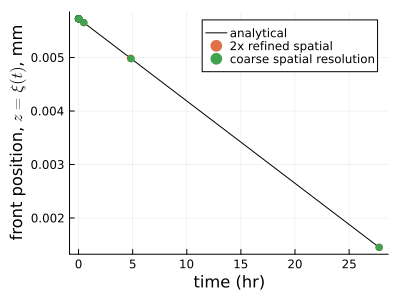

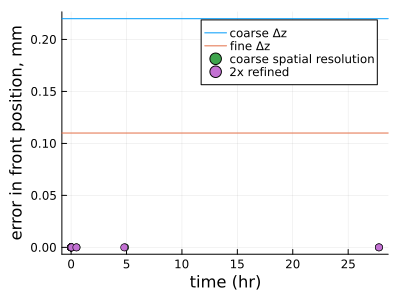

In [85]:
function case1_analyt_compare(simres, config)
    @unpack sol, dom = simres
    @unpack Kv, ρf, ΔH, ϵ = config[:cparams]
    @unpack Tsh = config[:controls]
    @unpack Tf0 = config
    Q_sh = Kv*(Tsh-Tf0)

    ts = sol.t
    zs = [get_subf_z(ϕ_T_from_u(sol(ti), dom)[1], dom) for ti in ts]

    vz = ustrip(u"m/s", -Q_sh/ ρf/ΔH / ϵ)
    zs_analyt = dom.zmax*(1-1e-4) .+ vz.*ts
    err_abs = abs.(zs_analyt .- zs)

    p1 = scatter(ts, zs, label="simulation")
    plot!(ts, zs_analyt, label="analytical")
    p2 = scatter(ts, err_abs, label="absolute error")
    hline!([dom.dr], label="grid spacing")
    plot!(xlabel="time")
    plot(p1, p2, layout=(2,1), size=(600,600))

    return ts, zs, zs_analyt
end

# display(case1_analyt_compare(simres1a, config_1a))
# display(case1_analyt_compare(simres1b, config_1b))
t1a, z1a, za1a = case1_analyt_compare(simres1a, config_1a)
t1b, z1b, za1b = case1_analyt_compare(simres1b, config_1b)

p = plot(size=(400, 300))
plot!(t1a/3600, za1a, label="analytical", c=:black)
scatter!(t1b/3600, z1b, markerstrokewidth=0, label="2x refined spatial")
scatter!(t1a/3600, z1a, markerstrokewidth=0, label="coarse spatial resolution")
plot!(xlabel="time (hr)", ylabel="front position, "*L"z=\xi(t)"*", mm")
display(p)
savefig(plotsdir("flat1d_analytical.svg"))

# p = hline([0], label=permutedims(["no error", ]))
# p = plot(size=(400,300), yscale=:log10)
p = plot(size=(400,300))
hline!([simres1a["dom"].dr*1e3], label="coarse Δz")
hline!([simres1b["dom"].dr*1e3], label="fine Δz")
scatter!(t1a/3600, abs.(za1a - z1a)*1e3, label="coarse spatial resolution")
scatter!(t1b/3600, abs.(za1b - z1b)*1e3, label="2x refined")
plot!(xlabel="time (hr)", ylabel="error in front position, mm")
savefig(plotsdir("flat1d_err_analytical.svg"))
p

### Case 2: 1D, r direction, only $Q_{ic}$

In [86]:
casename = "sim_1D_r_ice"

config_2a = deepcopy(config_base)
config_2a[:init_prof] = :cyl
config_2a[:controls][:Q_ic] = .1u"W/cm^3"

config_2b = deepcopy(config_2a)
config_2b[:simgridsize] = simgrid_fine

@time simres2a, simdatfile2a = produce_or_load(sim_from_dict, config_2a,
            datadir("sims", "1D"); pol_kwargs...)
@time simres2b, simdatfile2b = produce_or_load(sim_from_dict, config_2b,
            datadir("sims", "1D"); pol_kwargs...)
# simres2a = sim_from_dict(config_2a)
# simres2b = sim_from_dict(config_2b)
;

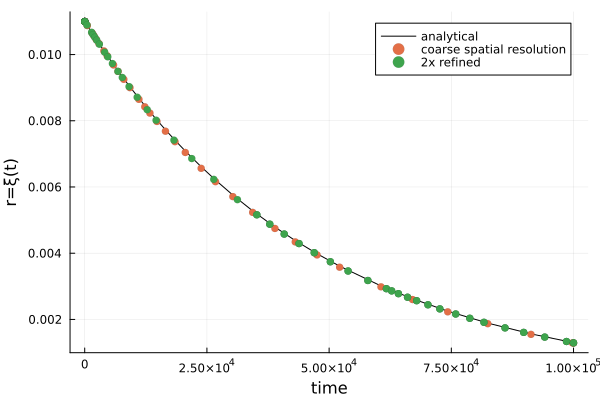

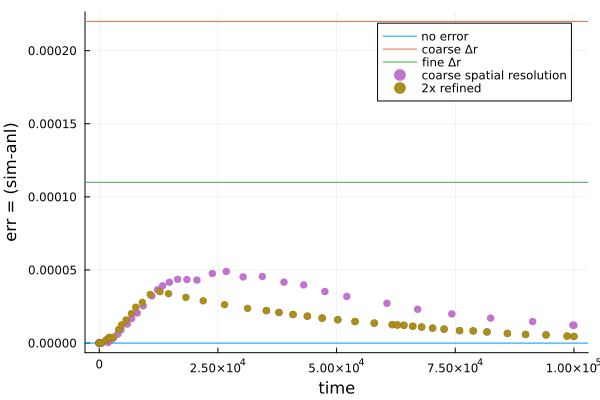

In [90]:
function case2_analyt_compare(simres, config)
    @unpack sol, dom = simres
    @unpack Kv, ρf, ΔH, ϵ = config[:cparams]
    Q_ic = config[:controls][:Q_ic]

    ts = sol.t
    rs = [get_subf_r(ϕ_T_from_u(sol(ti), dom)[1],dom) for ti in ts]

    rs_analyt = dom.rmax*(1-1e-4) * exp.(ustrip.(NoUnits, (-Q_ic/ρf/ΔH/ϵ/2 * ts*u"s") ))
    return ts, rs, rs_analyt
end

t2a, r2a, ra2a = case2_analyt_compare(simres2a, config_2a)
t2b, r2b, ra2b = case2_analyt_compare(simres2b, config_2b)

p = plot()
plot!(t2a, ra2a, label="analytical", c=:black)
scatter!(t2a, r2a, markerstrokewidth=0, label="coarse spatial resolution")
scatter!(t2b, r2b, markerstrokewidth=0, label="2x refined")
plot!(xlabel="time", ylabel="r=ξ(t)")
display(p)
savefig(plotsdir("rad1d_ic_analytical.svg"))
p = hline([0], label=permutedims(["no error", ]))
hline!([simres2a["dom"].dr], label="coarse Δr")
hline!([simres2b["dom"].dr], label="fine Δr")
scatter!(t2a, abs.(r2a - ra2a), markerstrokewidth=0, label="coarse spatial resolution")
scatter!(t2b, abs.(r2b - ra2b), markerstrokewidth=0, label="2x refined")
plot!(xlabel="time", ylabel="err = (sim-anl)")
savefig(plotsdir("rad1d_ic_err_analytical.svg"))
p

## Case 3: 1D, r direction, only glass heating

In [88]:
casename = "sim_1D_r_glass"

config_3a = deepcopy(config_base)
config_3a[:init_prof] = :cyl
config_3a[:Tgl0] = 243.15u"K"
config_3a[:cparams][:Kgl] = 50u"W/m^2/K"

config_3b = deepcopy(config_3a)
config_3b[:simgridsize] = simgrid_fine

@time simres3a, simdatfile3a = produce_or_load(sim_from_dict, config_3a,
            datadir("sims", "1D"); pol_kwargs...)
@time simres3b, simdatfile3b = produce_or_load(sim_from_dict, config_3b,
            datadir("sims", "1D"); pol_kwargs...)
# @time simres3a = sim_from_dict(config_3a, tf=1e6)
# @time simres3b = sim_from_dict(config_3b, tf=1e6)
;

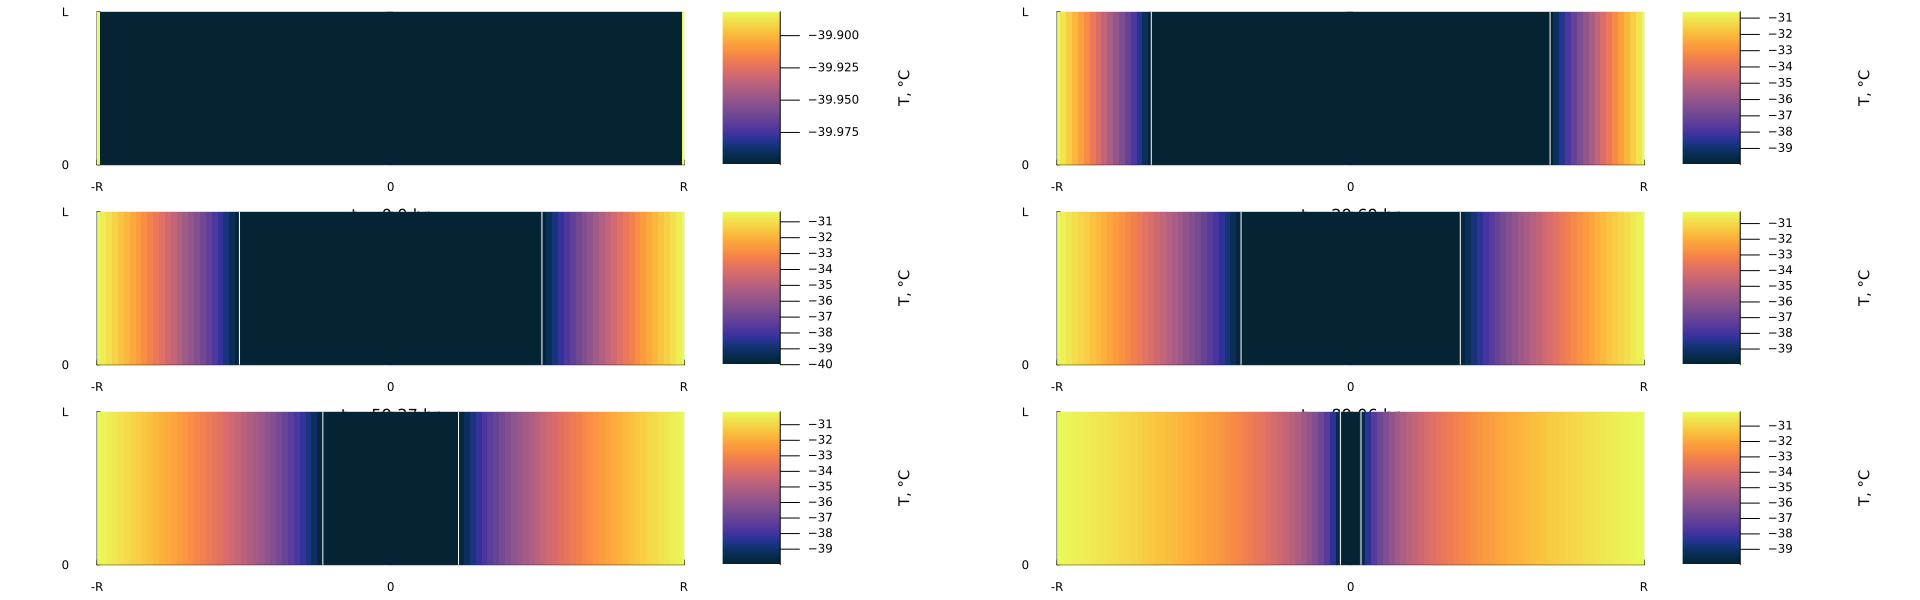

In [80]:
summaryplot(simres3a, config_3a)

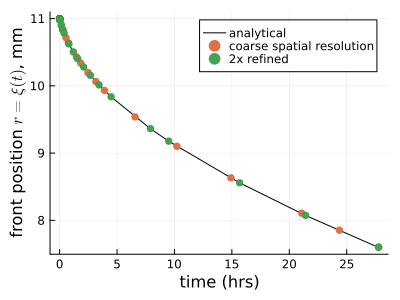

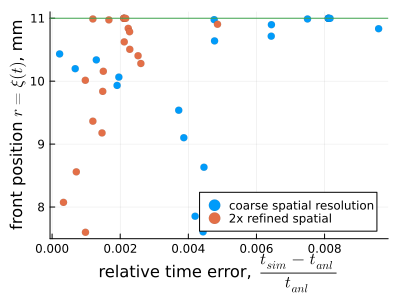

In [89]:
function case3_analyt_compare(simres, config)
    @unpack sol, dom = simres
    @unpack Kgl, k, ϵ, ρf, ΔH = config[:cparams]
    Tgl = config[:Tgl0]
    Tf = config[:Tf0]

    ts = sol.t *u"s"
    rs = [get_subf_r(ϕ_T_from_u(sol(ustrip(u"s", ti)), dom)[1],dom) for ti in ts] *u"m"

    # analytical easier in terms of ξ
    R = dom.rmax*u"m"
    R0 = R*(1 - 1e-4)
    rkk = R*Kgl/k
    A = rkk*(Tgl-Tf)
    B = rkk
    rrs = rs

    B = uconvert(NoUnits, B)

    term1 =@. 1/4*rrs^2 * (B*(2log(R/rrs)+1) + 2)
    term2 =   1/4*R0^2  * (B*(2log(R/R0 )+1) + 2)
    ts_analyt = @. ϵ*ρf*ΔH/A *(term2-term1)/k

    return ts, rs, ts_analyt
end
t3a, r3a, ta3a = case3_analyt_compare(simres3a, config_3a)
t3b, r3b, ta3b = case3_analyt_compare(simres3b, config_3b)
# t3c, r3c, ra3c = case3_analyt_compare(simres3c, config_3c)

p = plot(size=(400,300))
plot!(uconvert.(u"hr", ta3b), uconvert.(u"mm", r3b), label="analytical", c=:black)
scatter!(t3a, r3a, markerstrokewidth=0, label="coarse spatial resolution", )
scatter!(t3b, r3b, markerstrokewidth=0, label="2x refined")
# plot!(t3c, r3c, label="4x refined")
plot!(xlabel="time (hrs)", ylabel="front position " *L"r=\xi(t)"*", mm")
display(p)
savefig(plotsdir("rad1d_gl_analytical.svg"))

println("Drying time: ")
println("Coarse    : $(t3a[end])")
println("2x refined: $(t3b[end])")
println("Analytical: $(ta3a[end])")

dt_3a = t3a[end]/length(t3a)
dt_3b = t3b[end]/length(t3b)
# hline!([dt_3a], label="coarse Δt")
# hline!([dt_3b], label="fine Δt")
p = plot(size=(400, 300))
# scatter!((t3a - ta3a)/dt_3a, r3a ,markerstrokewidth=0, label="coarse spatial resolution")
# scatter!((t3b - ta3b)/dt_3b, r3b ,markerstrokewidth=0, label="2x refined")
scatter!(uconvert.(NoUnits, abs.((t3a - ta3a)./ta3a)), uconvert.(u"mm", r3a) ,markerstrokewidth=0, label="coarse spatial resolution")
scatter!(abs.((t3b - ta3b)./ta3b), r3b ,markerstrokewidth=0, label="2x refined spatial")
plot!(xlabel="relative time error, " * L"\frac{t_{sim}-t_{anl}}{t_{anl}}", ylabel="front position " *L"r=\xi(t)"*", mm")
# plot!(xlim=(0, .1))
hline!([simres3a["dom"].rmax]*1000, label="")
savefig(plotsdir("rad1d_gl_err_analytical.svg"))
p
# p
